# Spam Filter
I will be processing the content of the email and converting it into a list of words. Then comparsion would be made between this list and an another list which is named as "Keyword" list. This list contains essential words that would trigger the spam filter. This will also be containing words that won't trigger spam filter. 
Each word in the processed mail will be compared to the keyword list. If the word is present in the keyword list then the index of the keyword will be noted in another vector. This vector would be acting as nodes of the first layer.   

In [1]:
import nltk
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import numpy as np 
import string
import pandas as pd 
import csv
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#data_set = pd.read_csv('emails.csv')
#keyword = pd.read_csv('vocab.txt')
data_set = open('emails.csv')
# keyword = open('vocab.csv')  

In [3]:
file = csv.reader(data_set)
#word_list = csv.reader(keyword) # I am not using it anymore

In [4]:
###### Loading the data andseperating it into X and Y for ease of building.


X = []
Y = []
for (a,b) in file:
    X.append(a)
    Y.append(b)
    

In [5]:
#  IT IS OF NO USE (I TRIED IT SVM KERNEL method of SPAM FILTER) but it failed miserably
'''
spam_trigger = []
for word in word_list:
    print(word)
    x = np.squeeze(word)
    spam_trigger.append(str(x))  
print("done")    
'''    

'\nspam_trigger = []\nfor word in word_list:\n    print(word)\n    x = np.squeeze(word)\n    spam_trigger.append(str(x))  \nprint("done")    \n'

In [6]:
Y_data_set = np.zeros(shape = (1, len(Y)-1))
for i in range(1, len(Y)-1):
    Y_data_set[:, i] = Y[i]


In [7]:
print(Y_data_set.shape)
Y_model_data = Y_data_set

(1, 5728)


In [8]:
len(X)


5729

In [9]:
print(Y_model_data.shape)
print(Y_data_set.shape)

(1, 5728)
(1, 5728)


In [10]:
Y_model_data

array([[0., 1., 1., ..., 0., 0., 0.]])

# Data Pre Processing and data set distribution
   It is very important to preprocess data set to remove puctuautions, stop words ( which doesnot contribute to the learning of the neural networks ) and stemming is also important. Data set has been loaded. Now the data will further be divided into training, development and test set. Another list of name keyword will be loaded for the purpose of comparision.  

In [10]:
# This can be alternative for processing an email but now i am using TFIDF AND COUNT VECTORIZER FOR THIS METHOD
# I am not using it any more
'''

def process_mail(message, lower_case = True, stem = True, stop_words = True, gram = 2 ):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    return words    
    '''

# Initialization
I will write a functions that will initialize the parameters for the model. The function will be used to initialize parameters for a L layer model (General layer model). It will require a vector of units of layer andoutput parameters.



In [11]:
def initialize_parameters_L_layer(node_vector):
       
    parameters = {}
    L = len(node_vector)            

    for l in range(1, L):
        
        parameters['W' + str(l)] = np.random.randn(node_vector[l], node_vector[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros(shape = (node_vector[l], 1))
        
    return parameters

# Activation Function
Activation functions like sigmoid activation function and the sigmoid function will be required in the forward propogation and backward propogation. Derivative of these function will also be rquired hence its time to code them.

In [12]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A    

In [13]:
def relu(Z):
    A = np.maximum(Z, 0)
    return A    

In [14]:
def relu_derivative(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [15]:
def sigmoid_derivative(Z):
    A = Z * (1-Z)
    return A

# Forward propogation
Now that I am done with the initialization process, i am going to implement forward propogation

In [16]:
def forward_propogation(parameters, X):
    caches = []
    A = X
    L = len(parameters) // 2              
        
    for l in range(1, L):
        A_prev = A 
     
        Z = np.dot(parameters["W" + str(l)], A_prev) + parameters["b" + str(l)]
        linear_cache = (A_prev, parameters["W" + str(l)], parameters["b" + str(l)])
        A = relu(Z)
    
        cache = (linear_cache)
        caches.append(cache)
        
    Z_hat = np.dot(parameters["W" + str(L)], A) + parameters["b" + str(L)]
    linear_cache = (A, parameters["W" + str(L)], parameters["b" + str(L)])
    A_hat = sigmoid(Z_hat)
    cache = (linear_cache)
    caches.append(cache)
    
            
    return A_hat, caches

# Cost function

Now I will implement backward propagation. I also need to compute the cost to check if my model is actually learning.

In [17]:
def compute_cost(A_hat, Y):
    m = Y.shape[1]

    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(A_hat)) + np.multiply(1 - Y, np.log(1 - A_hat)))
    cost = np.squeeze(cost)     
    
    return cost

# Back propogation
Now that we have computed cost and forward propogation its time to code back propogation. I am doing it two steps because in one code cell it is becoming messy and difficult to debug.

In [18]:
def backward_prop_1(dA, cache, AL, Y_hat, activation):
    A_prev, W, b = cache
    
  
    m = A_prev.shape[1]
    
    if activation == "relu":
        
        dZ = dA * relu_derivative(np.dot(W, A_prev) + b)  
        dW = (1/m) * np.dot(dZ, A_prev.T)  
        db = (1/m) * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T, dZ) 
                
    elif activation == "sigmoid":
        
        # dZ = AL - Y_hat     # This line is for linear regression
        dZ = dA * sigmoid_derivative(AL) 
        dW = (1/m) * np.dot(dZ, A_prev.T)
        db = (1/m) * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T, dZ)
            
    return dA_prev, dW, db

In [19]:
def back_propogation(A_hat, Y, caches):
    grads = {}
    L = len(caches) 
    m = A_hat.shape[1]
    Y = Y.reshape(A_hat.shape) 
    
    dAL = - (np.divide(Y, A_hat) - np.divide(1 - Y, 1 - A_hat))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = backward_prop_1(dAL, current_cache, A_hat, Y, activation = "sigmoid")
    
    # Ranges from l-2 to 0
    for l in reversed(range(L-1)):
        
        current_cache = caches[l]
        
        dA_prev_temp, dW_temp, db_temp = backward_prop_1(grads["dA" + str(l+1)], current_cache, A_hat, Y, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
       
    return grads

# Update Parameters
Now its time to update parameters

In [20]:
def update_parameters(parameters, grads, learning_rate):
        
    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate * grads["dW" + str(l + 1)])  
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate * grads["db" + str(l + 1)])

    return parameters

In [21]:
def initialize_adam(parameters) :
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    for l in range(L):
    
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        
    return v, s

In [22]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
   
    
    L = len(parameters) // 2                 
    v_corrected = {}                         
    s_corrected = {}                         
    
    # Perform Adam update on all parameters
    for l in range(L):
       
        v["dW" + str(l+1)] = (v["dW" + str(l+1)] * beta1) + ((1-beta1) * grads["dW" + str(l+1)])
        v["db" + str(l+1)] = (v["db" + str(l+1)] * beta1) + ((1-beta1) * grads["db" + str(l+1)])
        
        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1-np.power(beta1,t)) 
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1-np.power(beta1,t))
        

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        
        s["dW" + str(l+1)] = (s["dW" + str(l+1)] * beta2) + ((1-beta2) * (grads["dW" + str(l+1)] ** 2))
        s["db" + str(l+1)] = (s["db" + str(l+1)] * beta2) + ((1-beta2) * (grads["db" + str(l+1)] ** 2))
        
        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1-np.power(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1-np.power(beta2,t))
        
        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate * (v_corrected["dW" + str(l+1)] / np.sqrt(s_corrected["dW" + str(l+1)] + epsilon))) 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate * (v_corrected["db" + str(l+1)] / np.sqrt(s_corrected["db" + str(l+1)] + epsilon)))
        

    return parameters, v, s

# Model
Now that we have trained all the required supplements. Here comes the real model.

In [23]:
def Spam_model(X, Y, node_vector,beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, learning_rate = 0.009, num_iterations = 2500, print_cost=True):
   
    costs = []
    t = 0
    
        # Parameters initialization.
    
    parameters = initialize_parameters_L_layer(node_vector)
    v, s = initialize_adam(parameters)
    
    for i in range(0, num_iterations):

        # Forward propagation
    
        A_hat, caches = forward_propogation(parameters, X)
              
        # Compute cost.
      
        cost = compute_cost(A_hat, Y)
          
        # Backward propagation.
      
        grads = back_propogation(A_hat, Y, caches)
      
 
        # Update parameters.
      
        #parameters = update_parameters(parameters, grads, learning_rate)
        t = t + 1 # Adam counter
        parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
                        
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters, A_hat



'''
##_________________________Model for mini batch gradient descent ( Massive dataset )______________________________________

def nn_model(X, Y, mini_batch_size , node_vector,beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, learning_rate = 0.0075, num_iterations = 1000, print_cost=True):
    
    costs = []
    t = 0
    mini_batch_size = mini_batch_size
    X_data = X
    Y_data = Y
        # Parameters initialization.
    
    parameters = initialize_parameters_L_layer(node_vector)
    v, s = initialize_adam(parameters)
    
    m = X.shape[1]
    print(m)
    mini_batches = math.floor(m/mini_batch_size) # 4869/128= 38
    print(mini_batches)
    for i in range(num_iterations):
        
        for k in range(mini_batches): 
'''
            
            # __________________________IMPORTANT_____________________________
            
'''
               While you are using mini batch gradient descent make sure that you shuffle each mini batch within itself
               This si an important practice which should be done. I am not doing it here. 
               But you can refer Improving Deep Neural Networks/Week2/Optimization+methods.ipynb from deep learning course
'''
          
'''  
            
            if k < (mini_batches-1):
                X = X_data[:, k*mini_batch_size : (k+1)*mini_batch_size]
                Y = Y_data[:, k*mini_batch_size : (k+1)*mini_batch_size]
            elif k >= mini_batches-1:
                X = X_data[:, (k+1)*mini_batch_size :]
                Y = Y_data[:, (k+1)*mini_batch_size :]

            # Forward propagation

            A_hat, caches = forward_propogation(parameters, X)

            # Compute cost.

            cost = compute_cost(A_hat, Y)

            # Backward propagation.

            grads = back_propogation(A_hat, Y, caches)


            # Update parameters.

            #parameters = update_parameters(parameters, grads, learning_rate)
            t = t + 1 # Adam counter
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                                   t, learning_rate, beta1, beta2,  epsilon)


        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters, A_hat
'''

'  \n            \n            if k < (mini_batches-1):\n                X = X_data[:, k*mini_batch_size : (k+1)*mini_batch_size]\n                Y = Y_data[:, k*mini_batch_size : (k+1)*mini_batch_size]\n            elif k >= mini_batches-1:\n                X = X_data[:, (k+1)*mini_batch_size :]\n                Y = Y_data[:, (k+1)*mini_batch_size :]\n\n            # Forward propagation\n\n            A_hat, caches = forward_propogation(parameters, X)\n\n            # Compute cost.\n\n            cost = compute_cost(A_hat, Y)\n\n            # Backward propagation.\n\n            grads = back_propogation(A_hat, Y, caches)\n\n\n            # Update parameters.\n\n            #parameters = update_parameters(parameters, grads, learning_rate)\n            t = t + 1 # Adam counter\n            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,\n                                                                   t, learning_rate, beta1, beta2,  epsilon)\n\n\n        # Pr

# Count Vector & Tfidf Vectorizer
These are two ways of converting an email content into the numerical data. these are just one liner code to apply STEMMING, AVOID STOP WORDS, TOKENIZE and CREATE DATA TO NUMBERS.

Countvectorizer works the same way as tfidf vector, What you have to do is just replace tfidf with CountVectorizer() only. Rest remains the same. Tfidf works better in large data set so i have used it here. I also tried to do it myself. It was actualy what in learnt in machine learning course to develop spam filter in octave using SVM Kernel features. BU tut went wrong and was not working properly because my cost graph eventually stopped at 0.59 at didnot decreased from it any further. So I am using them now.

In [24]:

cv = TfidfVectorizer(min_df = 1, stop_words = 'english')

In [25]:
# I am NOT USING IT anymore
'''
def Myway_spam_inputvec():
    
    # This is what i did (for SVM KERNEL method) but it is not working properly here.
    
    X_data_set = np.random.randn(len(spam_trigger), len(X)-1)
    t = 0
    for i in range(len(X)-1):
        X_data = []
        message = X[i+1]
        print(f"Processing the {i} column of the input layer")
        pure_words = process_mail(message, lower_case = True, stem = True, stop_words = False, gram = 2 )

        #print(words)#  Apply it to confirm whether the list is correct or not

        for words in spam_trigger:
            for email_words in pure_words:
                if email_words == words:
                    X_data.append(spam_trigger.index(words)) 

            X_data.append(0)


        for k in range(len(spam_trigger)):
            X_data_set[k][t] = X_data[k]

        t += 1
            # A column vector is made of the required X input but switch between train set dev set and test set is still pending.
            '''

'\ndef Myway_spam_inputvec():\n    \n    # This is what i did (for SVM KERNEL method) but it is not working properly here.\n    \n    X_data_set = np.random.randn(len(spam_trigger), len(X)-1)\n    t = 0\n    for i in range(len(X)-1):\n        X_data = []\n        message = X[i+1]\n        print(f"Processing the {i} column of the input layer")\n        pure_words = process_mail(message, lower_case = True, stem = True, stop_words = False, gram = 2 )\n\n        #print(words)#  Apply it to confirm whether the list is correct or not\n\n        for words in spam_trigger:\n            for email_words in pure_words:\n                if email_words == words:\n                    X_data.append(spam_trigger.index(words)) \n\n            X_data.append(0)\n\n\n        for k in range(len(spam_trigger)):\n            X_data_set[k][t] = X_data[k]\n\n        t += 1\n            # A column vector is made of the required X input but switch between train set dev set and test set is still pending.\n       

In [26]:
X_completedata = cv.fit_transform(X[1:])

In [27]:
X_model_data = X_completedata.toarray()

In [28]:
X_model_data


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.11913249, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [29]:
print(X_model_data.shape)


(5728, 36996)


In [30]:
# An example of selected words by TFIDF Vectorizer of the first text email of the text array(X)

cv.inverse_transform(X_model_data[0])

[array(['100', 'affordability', 'aim', 'automaticaily', 'benefits',
        'break', 'budget', 'business', 'catchy', 'change', 'changes',
        'ciear', 'clear', 'collaboration', 'company', 'content',
        'convenience', 'corporate', 'creativeness', 'days', 'distinctive',
        'drafts', 'easier', 'easy', 'effective', 'efforts', 'extra',
        'fees', 'formats', 'gaps', 'good', 'guaranteed', 'hand', 'hard',
        'havinq', 'hotat', 'identity', 'ieader', 'image', 'information',
        'interested', 'iogo', 'irresistible', 'isguite', 'isoverwhelminq',
        'letsyou', 'list', 'logo', 'logos', 'look', 'love', 'lt', 'make',
        'management', 'market', 'marketing', 'naturally', 'nowadays',
        'ordered', 'organization', 'original', 'outstanding', 'portfolio',
        'practicable', 'products', 'promise', 'promptness', 'provide',
        'provided', 'really', 'recollect', 'reflect', 'result',
        'satisfaction', 'shouldn', 'specially', 'stationery', 'statlonery',
  

In [31]:
# May be used but not using it here
# I am not using it here
'''
def random_shuffle_two_vec(X, Y):
    a = X
    b = Y

    c = list(zip(a, b))

    np.random.shuffle(c)

    a, b = zip(*c)

    return a, b
    '''

'\ndef random_shuffle_two_vec(X, Y):\n    a = X\n    b = Y\n\n    c = list(zip(a, b))\n\n    np.random.shuffle(c)\n\n    a, b = zip(*c)\n\n    return a, b\n    '

In [32]:
X_model_data_actual = X_model_data.T

train_set_X = X_model_data_actual[:, :4869]

X_test = X_model_data_actual[:, 4869:]
Y_train = Y_model_data[:, :4869]

Y_test = Y_model_data[:, 4869:]

In [33]:
print(train_set_X.shape)
print(X_test.shape)
print(Y_train.shape)

(36996, 4869)
(36996, 859)
(1, 4869)


Cost after iteration 0: 0.693148
Cost after iteration 100: 0.165143
Cost after iteration 200: 0.093161
Cost after iteration 300: 0.058439
Cost after iteration 400: 0.039975
Cost after iteration 500: 0.029186
Cost after iteration 600: 0.022370
Cost after iteration 700: 0.017792
Cost after iteration 800: 0.014564
Cost after iteration 900: 0.012200
Cost after iteration 1000: 0.010414
Cost after iteration 1100: 0.009030
Cost after iteration 1200: 0.007936
Cost after iteration 1300: 0.007054
Cost after iteration 1400: 0.006334


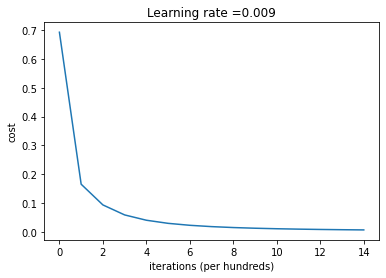

In [50]:
parameters, A_hat = Spam_model(train_set_X, Y_train, node_vector = [36996, 20, 5, 1], num_iterations = 1500, print_cost = True)

## Prediction

In [47]:
A_hat_test, cache = forward_propogation(parameters, X_test)

In [48]:
A_hat_pred = np.round(A_hat_test)

In [49]:
### Prediction

A_hat_train, cache = forward_propogation(parameters, train_set_X)

In [50]:
A_hat_train_pred = np.round(A_hat_train)

In [51]:
A_hat_train_pred[:, :]
    

array([[1., 1., 1., ..., 0., 0., 0.]])

In [52]:
Y_train[:, :]

array([[0., 1., 1., ..., 0., 0., 0.]])

In [53]:
hallahu = A_hat_train_pred - Y_train
print(hallahu)

[[1. 0. 0. ... 0. 0. 0.]]


In [54]:
pred_vec=[]
for x in hallahu:
    pred_vec.append(x)
print(pred_vec)    

[array([1., 0., 0., ..., 0., 0., 0.])]


In [55]:
k = 0
for assum in pred_vec:
    for numb in assum:
        if numb == 0:
            k += 1
print(k)        

4868


In [64]:
l = 4868/4869
print(f"Train set accuracy is {l}")

Train set accuracy is 0.9997946190182789


In [60]:
delta= np.squeeze(A_hat_pred - Y_test)

In [63]:
t=0
for k in delta:
    if k != 0:
        t=t+1
        
print(t)    

1


In [68]:
cal = (859-1)/859
print(f"Test set accuracy is {cal}")

Test set accuracy is 0.9988358556461001
